<a href="https://colab.research.google.com/github/Taghr66d/MSc-SummerProject2025/blob/main/Cusp_vs_Blip_in_Real_Noise_(Acc_90_)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [3]:
import numpy as np

cusp_data = np.load("cusp_real_noise_10k.npz")
blip_data = np.load("blip_real_noise_10k.npz")


X_blip = blip_data["X"]
y_blip = blip_data["y"]

X_cusp = cusp_data["X"]
y_cusp = cusp_data["y"]


# Combine and relabel (blip = 0, cusp = 1)
X = np.concatenate([X_blip, X_cusp], axis=0)
y = np.concatenate([np.zeros_like(y_blip), np.ones_like(y_cusp)], axis=0)


In [4]:
print(X.shape)
print(y.shape)

(20000, 1024)
(20000,)


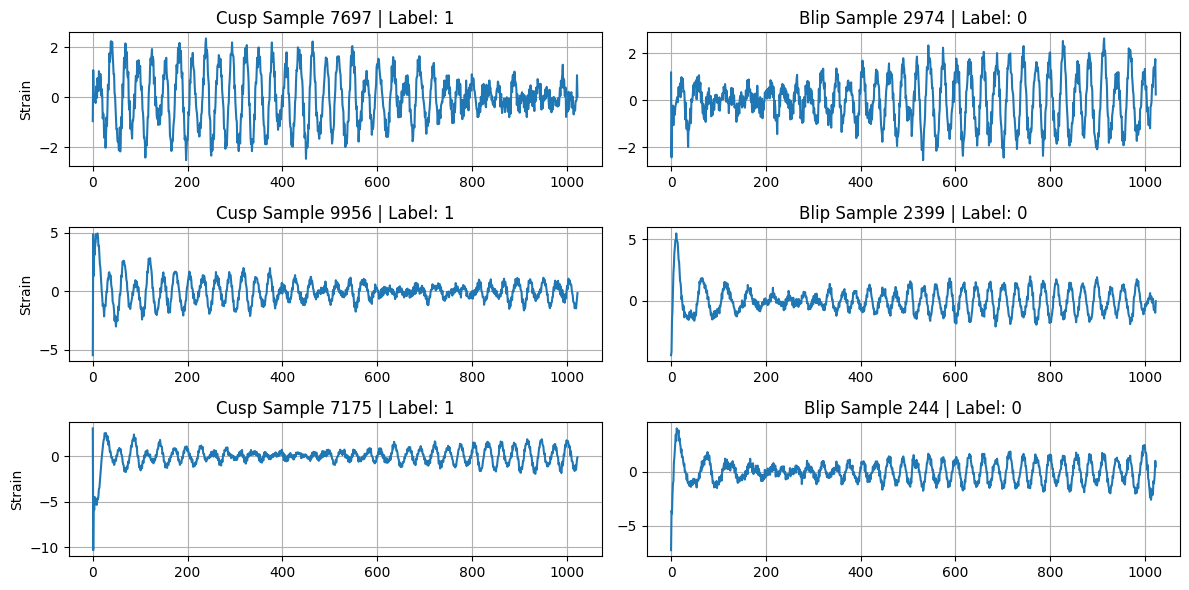

In [5]:
import numpy as np
import matplotlib.pyplot as plt


X1 = cusp_data["X"]
y1 = cusp_data["y"]
X2 = blip_data["X"]
y2 = blip_data["y"]

n_samples = 3

plt.figure(figsize=(12, n_samples * 2))

for i in range(n_samples):
    # Random cusp
    idx1 = np.random.randint(0, len(X1))
    plt.subplot(n_samples, 2, i * 2 + 1)
    plt.plot(X1[idx1])
    plt.title(f"Cusp Sample {idx1} | Label: {int(y1[idx1])}")
    plt.ylabel("Strain")
    plt.grid(True)

    # Random blip
    idx2 = np.random.randint(0, len(X2))
    plt.subplot(n_samples, 2, i * 2 + 2)
    plt.plot(X2[idx2])
    plt.title(f"Blip Sample {idx2} | Label: {int(y2[idx2])}")
    plt.grid(True)

plt.tight_layout()
plt.show()


In [6]:
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt


def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    return butter(order, [low, high], btype='band')


def apply_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return filtfilt(b, a, data)

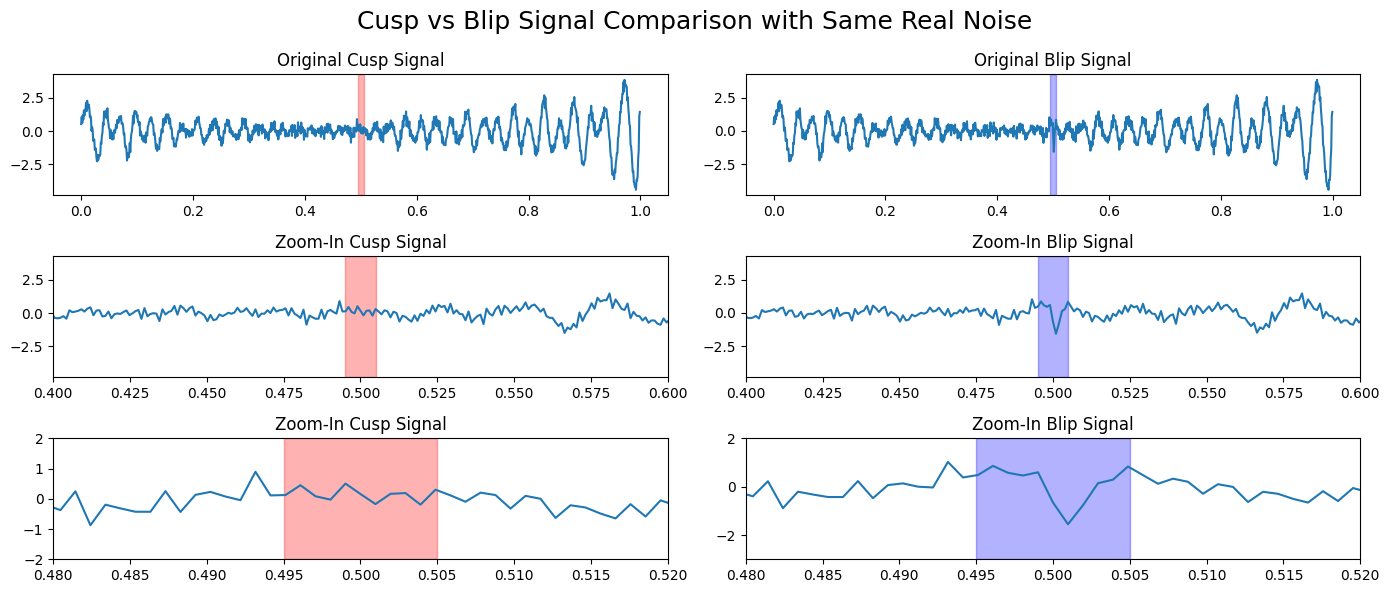

In [173]:
fs = 1024
lowcut = 20
highcut = 50


signal_cusp = X_cusp[100]
signal_blip = X_blip[100]
t = np.arange(len(signal_cusp)) / fs

# Filter signals
filtered_cusp = apply_bandpass_filter(signal_cusp, lowcut, highcut, fs)
filtered_blip = apply_bandpass_filter(signal_blip, lowcut, highcut, fs)

######## Cusp signal ##########
plt.figure(figsize=(14, 6))

plt.subplot(3, 2, 1)
plt.plot(t, signal_cusp)
plt.axvspan(0.495,0.505, color='r', alpha=0.3)
plt.title("Original Cusp Signal")

plt.subplot(3, 2, 3)
plt.plot(t, signal_cusp)
plt.axvspan(0.495,0.505, color='r', alpha=0.3)
plt.title("Zoom-In Cusp Signal")
plt.xlim(0.400, 0.600)

plt.subplot(3, 2, 5)
plt.plot(t, signal_cusp)
plt.axvspan(0.495,0.505, color='r', alpha=0.3)
plt.title("Zoom-In Cusp Signal")
plt.xlim(0.480, 0.520)
plt.ylim(-2, 2)


####### Blip Signal #########
plt.subplot(3, 2, 2)
plt.plot(t, signal_blip)
plt.axvspan(0.495,0.505, color='b', alpha=0.3)
plt.title("Original Blip Signal")

plt.subplot(3, 2, 4)
plt.plot(t, signal_blip)
plt.axvspan(0.495,0.505, color='b', alpha=0.3)
plt.title("Zoom-In Blip Signal")
plt.xlim(0.400, 0.600)

plt.subplot(3, 2, 6)
plt.plot(t, signal_blip)
plt.axvspan(0.495,0.505, color='b', alpha=0.3)
plt.title("Zoom-In Blip Signal")
plt.xlim(0.480, 0.520)
plt.ylim(-3, 2)

plt.suptitle("Cusp vs Blip Signal Comparison with Same Real Noise", fontsize=18)
plt.tight_layout()
plt.show()

In [91]:
# Reshape for CNN input
X = X[..., np.newaxis]  # shape = (samples, 1024, 1)

In [93]:
from sklearn.model_selection import train_test_split

def split_data(X, y, val_size=0.15, test_size=0.15):
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)
    val_ratio = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_ratio, stratify=y_temp, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y, val_size=0.15, test_size=0.15)


In [94]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)


(14000, 1024, 1) (3000, 1024, 1) (3000, 1024, 1)
(14000,) (3000,) (3000,)


In [95]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv1D(32, 7, activation='relu', input_shape=X.shape[1:]),
    BatchNormalization(),
    MaxPooling1D(2),

    Conv1D(64, 5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),

    GlobalAveragePooling1D(),

    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1018, 32)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1018, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 509, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 505, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 505, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 252, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,169 (59.25 KB)

 Trainable params: 14,977 (58.50 KB)

 Non-trainable params: 192 (768.00 B)

In [96]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64,
                    validation_data=(X_val, y_val))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 43s 183ms/step - accuracy: 0.5280 - loss: 0.6881 - val_accuracy: 0.5000 - val_loss: 0.7180
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 39s 176ms/step - accuracy: 0.8077 - loss: 0.4479 - val_accuracy: 0.5060 - val_loss: 0.9415
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 44s 202ms/step - accuracy: 0.8570 - loss: 0.3532 - val_accuracy: 0.7627 - val_loss: 0.5632
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 77s 178ms/step - accuracy: 0.8701 - loss: 0.3289 - val_accuracy: 0.8233 - val_loss: 0.4380
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 41s 177ms/step - accuracy: 0.8779 - loss: 0.3138 - val_accuracy: 0.8917 - val_loss: 0.2927
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 40s 173ms/step - accuracy: 0.8915 - loss: 0.2879 - val_accuracy: 0.8710 - val_loss: 0.3269
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 42s 176ms/step - accuracy: 0.8976 - loss: 0.2722 - val_accuracy: 0.8963 - val_loss: 0.2838
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 41s 176ms/step - accuracy: 0.8973 - loss: 0

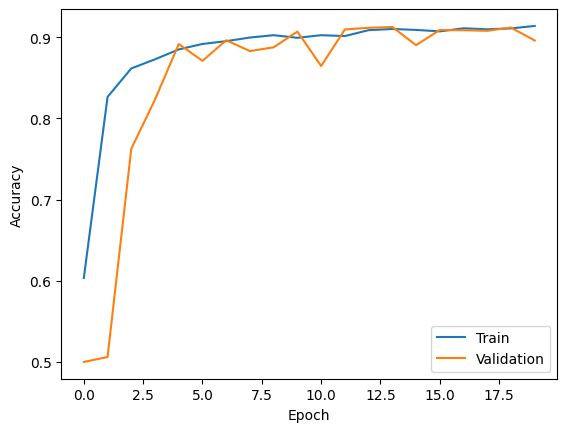

In [97]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

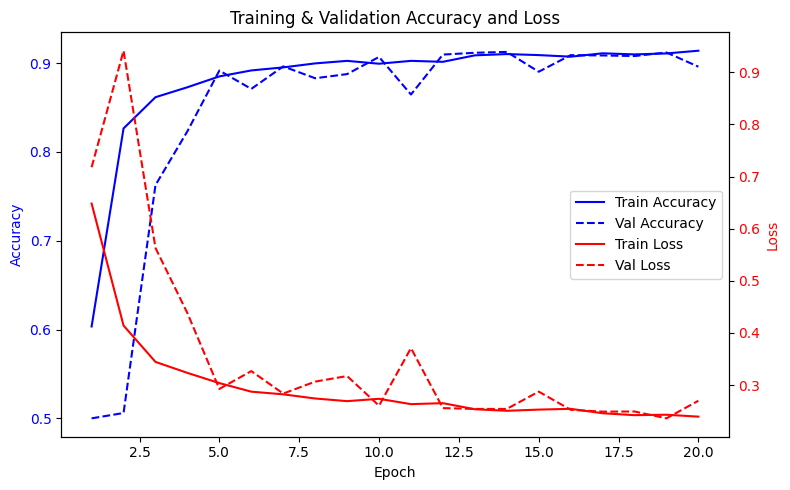

In [98]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history['accuracy']) + 1)

fig, ax1 = plt.subplots(figsize=(8, 5))


ax1.plot(epochs, history.history['accuracy'], 'b-', label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], 'b--', label='Val Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='b')
ax1.tick_params(axis='y', labelcolor='b')


ax2 = ax1.twinx()
ax2.plot(epochs, history.history['loss'], 'r-', label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], 'r--', label='Val Loss')
ax2.set_ylabel('Loss', color='r')
ax2.tick_params(axis='y', labelcolor='r')


lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='center right')

plt.title('Training & Validation Accuracy and Loss')
plt.tight_layout()
plt.show()

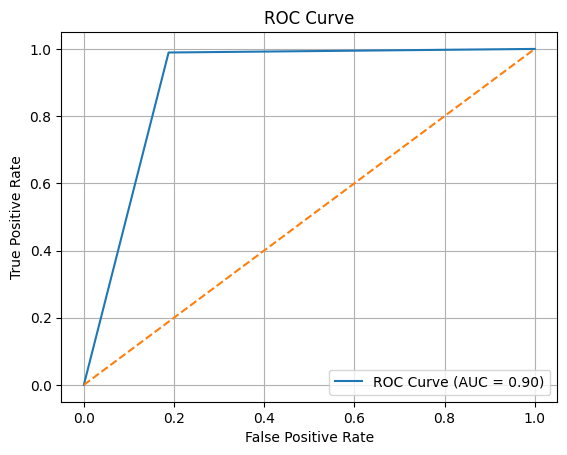

In [175]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--')  # random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


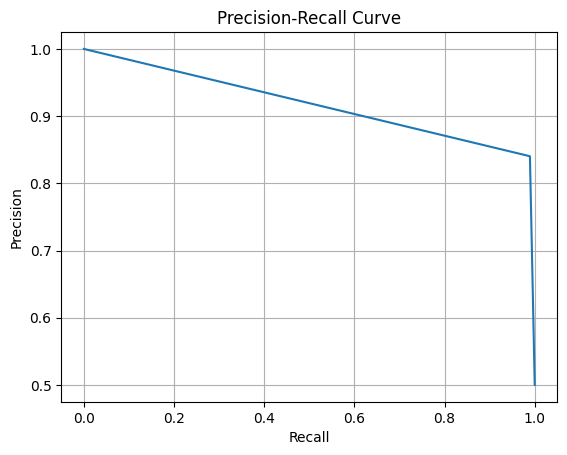

In [176]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_pred)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()


In [99]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9035 - loss: 0.2631
Test Accuracy: 0.9007, Test Loss: 0.2843


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
Misclassified examples: 286


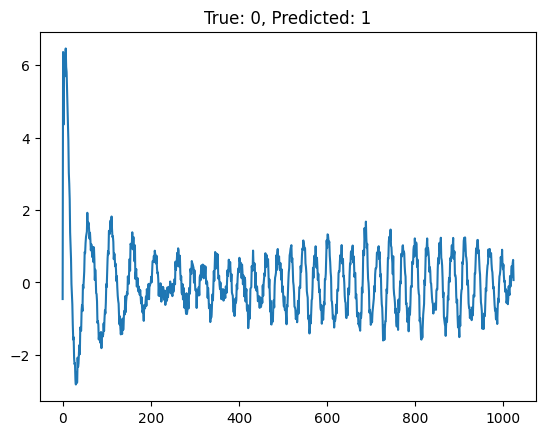

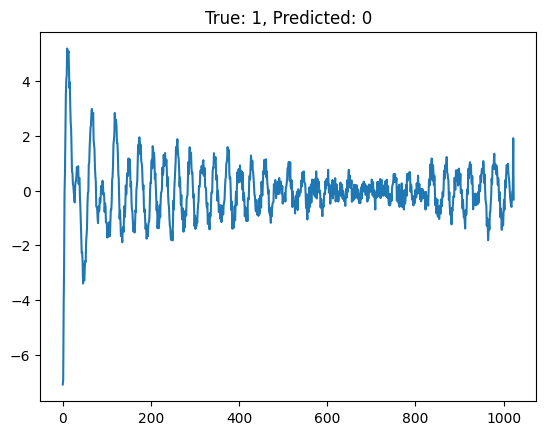

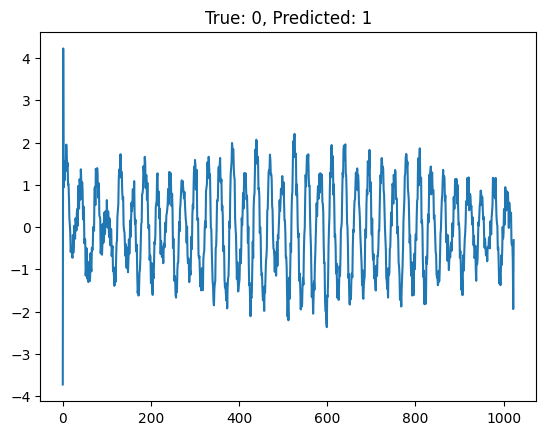

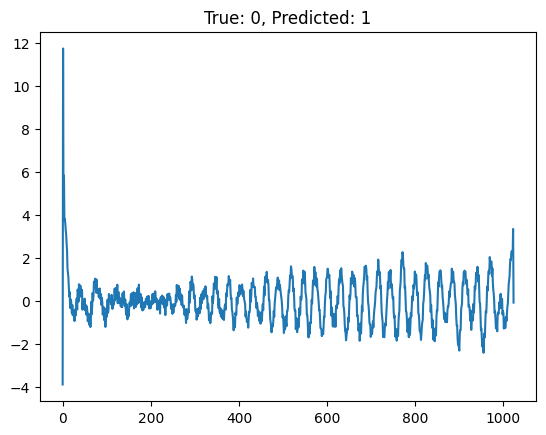

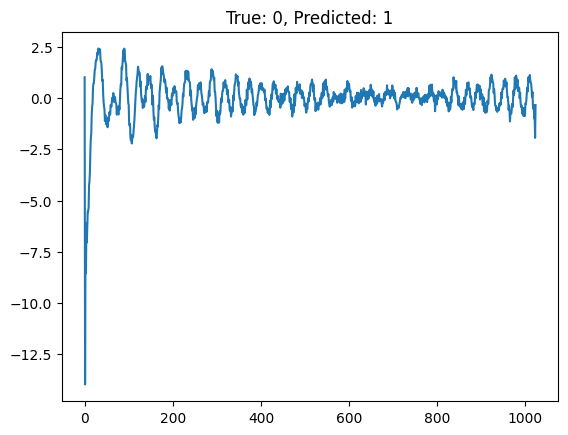

In [19]:
y_pred = (model.predict(X_test) > 0.5).astype(int)
misclassified_idx = np.where(y_pred.flatten() != y_test)[0]

print(f"Misclassified examples: {len(misclassified_idx)}")


import matplotlib.pyplot as plt
for i in misclassified_idx[:5]:
    plt.plot(X_test[i].squeeze())
    plt.title(f"True: {y_test[i]}, Predicted: {y_pred[i][0]}")
    plt.show()


In [20]:
probs = model.predict(X_test)
for i in misclassified_idx[:5]:
    prob = probs[i][0]
    print(f"True: {y_test[i]}, Pred: {int(prob > 0.5)}, Confidence: {prob:.4f}")


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
True: 0, Pred: 1, Confidence: 0.6977
True: 1, Pred: 0, Confidence: 0.3845
True: 0, Pred: 1, Confidence: 0.5463
True: 0, Pred: 1, Confidence: 0.9354
True: 0, Pred: 1, Confidence: 0.8866


In [21]:
low_conf_idx = np.where((probs.flatten() > 0.3) & (probs.flatten() < 0.7))[0]
print(f"Low-confidence samples: {len(low_conf_idx)}")


Low-confidence samples: 188


94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step


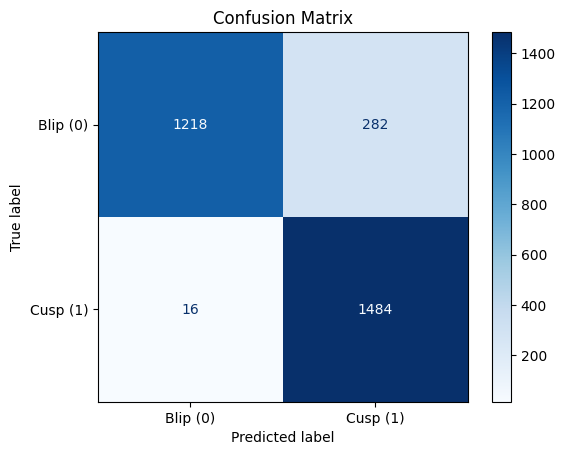

In [100]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

probs = model.predict(X_test)
y_pred = (probs > 0.5).astype(int).flatten()

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Blip (0)", "Cusp (1)"])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [131]:
print(model.input_shape)


(None, 1024, 1)


In [133]:
import tensorflow as tf
import numpy as np

index = 22
sample = X[index]  # shape: (1024,)
sample = sample[np.newaxis, :, np.newaxis]  # shape: (1, 1024, 1)


sample_tensor = tf.convert_to_tensor(sample, dtype=tf.float32)


prediction = model(sample_tensor, training=False)
predicted_class = np.argmax(prediction.numpy())


print(f"Sample #{index}")
print(f"True label: {int(y[index])} (0 = blip, 1 = cusp)")
print(f"Predicted class: {predicted_class}")
print(f"Class probabilities: {prediction.numpy()[0]}")


Sample #22
True label: 0 (0 = blip, 1 = cusp)
Predicted class: 0
Class probabilities: [0.06626917]
